In [164]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from pathlib import Path
from glob import glob
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [165]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    Linewidth_glass = glass_data['linewidth'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.96
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    dLinewidth_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_data)
        if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
            dEres_IG_list.append(dEres_IG.values)
            dLinewidth_IG_list.append(dLinewidth_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
    C = dEres_IG_mean / dnsub_IG
    D = dLinewidth_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    target_Linewidth = D*(target_nsub - glass_nsub) + glass_data['linewidth']
    return target_Eres, target_Linewidth

In [248]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

(1701, 7)


In [69]:
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)

exp_ito_data = exp_ito_data[(exp_ito_data['length'] > 80) & (exp_ito_data['length'] < 95)] 
exp_ito_data = exp_ito_data[(exp_ito_data['width'] > 28) & (exp_ito_data['width'] < 31)] 
exp_ito_data = exp_ito_data.reset_index(drop=True)

# create the specific number of data
# exp_glass_data = exp_glass_data.sample(50, random_state=42)
exp_ito_data = exp_ito_data.sample(30, random_state=42)
exp_ito_data = exp_ito_data.reset_index(drop=True)

X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
yw_exp_ito = exp_ito_data['width']
yl_exp_ito = exp_ito_data['length']
print(X_exp_ito.shape)

(30, 2)


In [249]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

# ito_data = ito_data.sample(1000, random_state=42)
# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']
print(X_ito.shape)

(1701, 2)
(3292, 2)


In [250]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

## Glass-trained model using ITO testing

In [14]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_exp_ito)

rel_errw1 = (abs(yw_exp_ito-yw_pred1)/yw_exp_ito)*100
rmspew1 = (sum(rel_errw1**2)/len(yw_pred1)) ** 0.5
maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_exp_ito)

rel_errl1 = (abs(yl_exp_ito-yl_pred1)/yl_exp_ito)*100
rmspel1 = (sum(rel_errl1**2)/len(yl_pred1)) ** 0.5
mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)

print(rmspew1, rmspel1)
print(maew1, mael1)

7.287475207036924 12.350378904430883
1.7321221389721402 9.52287574927462


Text(0.01, 0.95, 'B')

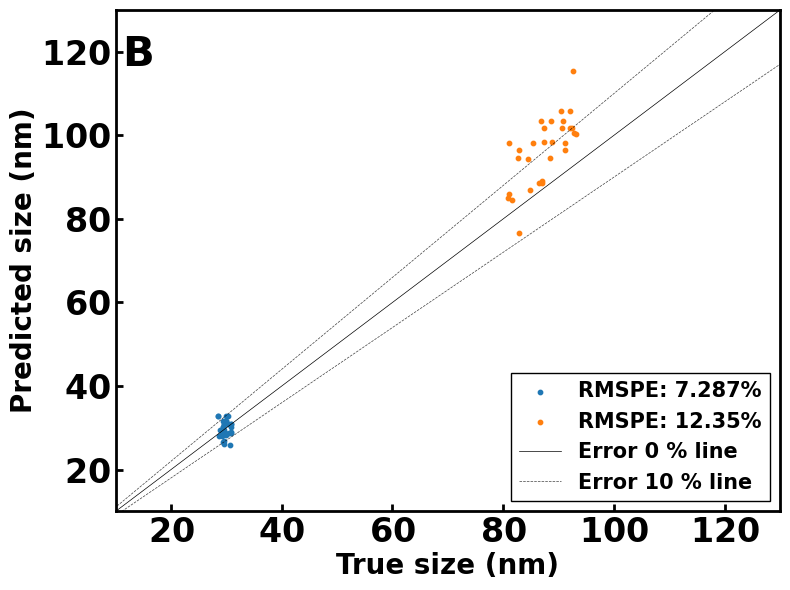

In [15]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, yw_pred1, s=10, label=f'RMSPE: {round(rmspew1, 3)}%')
ax.scatter(yl_exp_ito, yl_pred1, s=10, label=f'RMSPE: {round(rmspel1, 3)}%')
    
x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(10, 130)
ax.set_ylim(10, 130)
ax.legend(loc='lower right', fontsize=15)
ax.text(0.01, 0.95, 'B', ha='left', va='top', transform=ax.transAxes, fontsize=30)

## Figure Corrected glass-trained model using ITO testing

In [16]:
ITO_nsub = 1.96
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, combined_data, target_nsub=ITO_nsub)

X_glass['eres'] = ITO_Eres
X_glass['linewidth'] = ITO_Linewidth
print(X_glass.head())

       eres  linewidth
0  1.930700   0.157127
1  1.635627   0.100955
2  1.736884   0.105641
3  1.551191   0.090922
4  1.805388   0.121025


In [17]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred2 = gsw.predict(X_exp_ito)

rel_errw2 = (abs(yw_exp_ito-yw_pred2)/yw_exp_ito)*100
rmspew2 = (sum(rel_errw2**2)/len(yw_pred2)) ** 0.5
maew2 = mean_absolute_error(yw_exp_ito, yw_pred2)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred2 = gsl.predict(X_exp_ito)

rel_errl2 = (abs(yl_exp_ito-yl_pred2)/yl_exp_ito)*100
rmspel2 = (sum(rel_errl2**2)/len(yl_pred2)) ** 0.5
mael2 = mean_absolute_error(yl_exp_ito, yl_pred2)

print(rmspew2, rmspel2)
print(maew2, mael2)

11.12924499222028 8.999431698849309
2.8337400675250675 6.939843958633961


Text(0.01, 0.95, 'C')

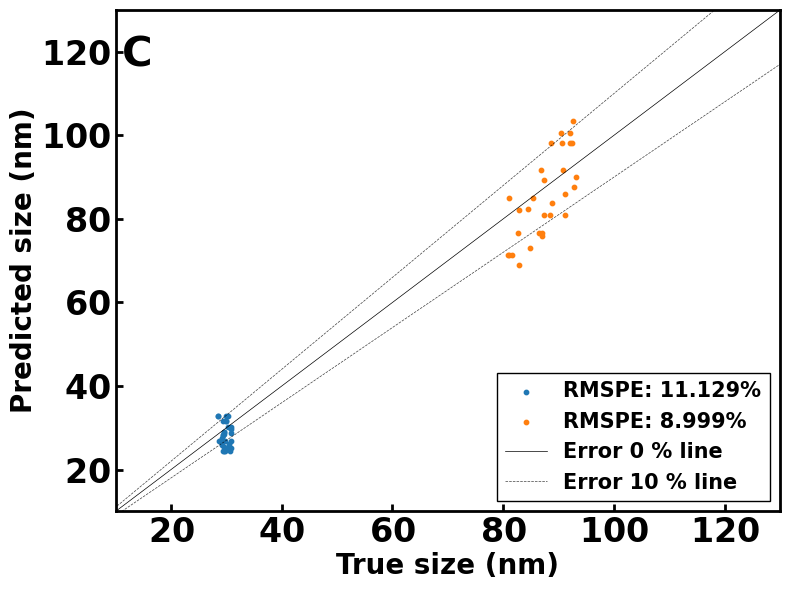

In [18]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, yw_pred2, s=10, label=f'RMSPE: {round(rmspew2, 3)}%')
ax.scatter(yl_exp_ito, yl_pred2, s=10, label=f'RMSPE: {round(rmspel2, 3)}%')
    
x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(10, 130)
ax.set_ylim(10, 130)
ax.legend(loc='lower right', fontsize=15)
ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

## Comparison plots 

### layered scattering

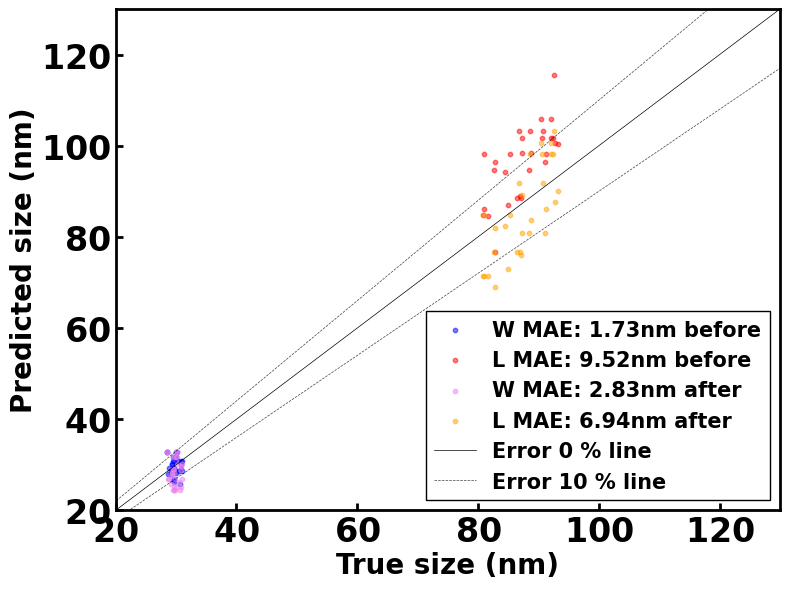

In [144]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, yw_pred1, s=10, c='b', alpha=.5, label=f'W MAE: {round(maew1, 2)}nm before')
ax.scatter(yl_exp_ito, yl_pred1, s=10, c='r', alpha=.5, label=f'L MAE: {round(mael1, 2)}nm before')

ax.scatter(yw_exp_ito, yw_pred2, s=10, c='violet', alpha=.5, label=f'W MAE: {round(maew2, 2)}nm after')
ax.scatter(yl_exp_ito, yl_pred2, s=10, c='orange', alpha=.5, label=f'L MAE: {round(mael2, 2)}nm after')

x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(20, 130)
ax.set_ylim(20, 130)
ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'B', ha='left', va='top', transform=ax.transAxes, fontsize=30)

### residual plots

(-25.000, 25.000)

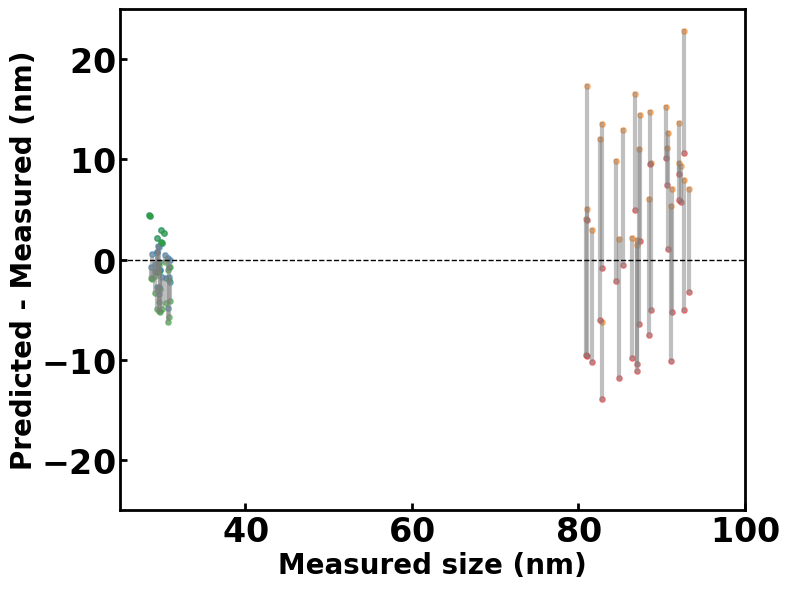

In [95]:
fig, ax = plt.subplots()

# Glass to ITO
ax.scatter(yw_exp_ito, yw_pred1-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew1, 3)} nm')
ax.scatter(yl_exp_ito, yl_pred1-yl_exp_ito, s=15, alpha=.5, label=f'MAE: {round(mael1, 3)} nm')

# Corrected Glass to ITO
ax.scatter(yw_exp_ito, yw_pred2-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew2, 3)} nm')
ax.scatter(yl_exp_ito, yl_pred2-yl_exp_ito, s=15, alpha=.5, label=f'MAE: {round(mael2, 3)} nm')

for i in range(len(yw_exp_ito)):
    ax.plot([yw_exp_ito[i], yw_exp_ito[i]], [yw_pred1[i] - yw_exp_ito[i], yw_pred2[i] - yw_exp_ito[i]], color='gray', alpha=0.5)

for i in range(len(yl_exp_ito)):
    ax.plot([yl_exp_ito[i], yl_exp_ito[i]], [yl_pred1[i] - yl_exp_ito[i], yl_pred2[i] - yl_exp_ito[i]], color='gray', alpha=0.5)    
    
ax.axhline(y=0, lw=1, ls="--", c='k')

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Predicted - Measured (nm)')
ax.set_xlim(25, 100)
ax.set_ylim(-25, 25)
# ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

### error distribution plots

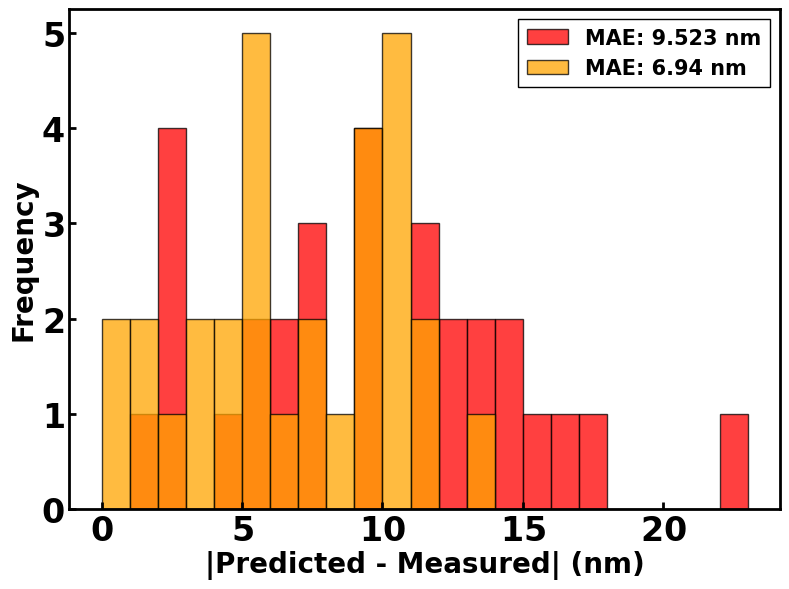

In [103]:
fig, ax = plt.subplots()

# Glass to ITO
bin_width = 1
# bins1 = np.arange(0, max(abs(yw_pred1-yw_exp_ito)) + bin_width, bin_width)
# ax.hist(abs(yw_pred1-yw_exp_ito), bins=bins1, color='blue', edgecolor='black', alpha=0.75, label=f'MAE: {round(maew1, 3)} nm')

bins2 = np.arange(0, max(abs(yl_pred1-yl_exp_ito)) + bin_width, bin_width)
ax.hist(abs(yl_pred1-yl_exp_ito), bins=bins2, color='red', edgecolor='black', alpha=0.75, label=f'MAE: {round(mael1, 3)} nm')

# Corrected Glass to ITO
# bins3 = np.arange(0, max(abs(yw_pred2-yw_exp_ito)) + bin_width, bin_width)
# ax.hist(abs(yw_pred2-yw_exp_ito), bins=bins3, color='violet', edgecolor='black', alpha=0.75, label=f'MAE: {round(maew2, 3)} nm')

bins4 = np.arange(0, max(abs(yl_pred2-yl_exp_ito)) + bin_width, bin_width)
ax.hist(abs(yl_pred2-yl_exp_ito), bins=bins4, color='orange', edgecolor='black', alpha=0.75, label=f'MAE: {round(mael2, 3)} nm')

ax.set_xlabel('|Predicted - Measured| (nm)')
ax.set_ylabel('Frequency')
# ax.set_xlim(10, 180)
# ax.set_ylim(10, 130)
ax.legend(loc='upper right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

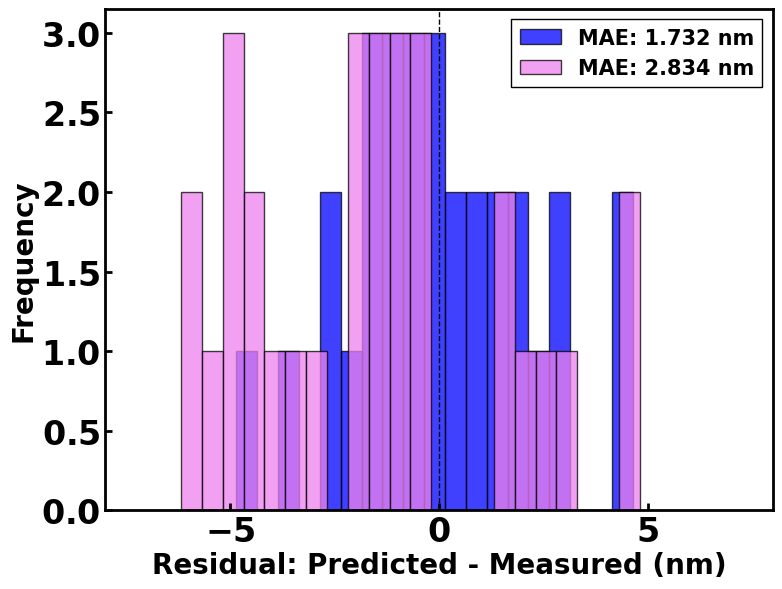

In [116]:
fig, ax = plt.subplots()

# Glass to ITO
bin_width = 0.5
bins1 = np.arange(min(yw_pred1-yw_exp_ito), max(yw_pred1-yw_exp_ito) + bin_width, bin_width)
ax.hist(yw_pred1-yw_exp_ito, bins=bins1, color='blue', edgecolor='black', alpha=0.75, label=f'MAE: {round(maew1, 3)} nm')

# bins2 = np.arange(min(yl_pred1-yl_exp_ito), max(yl_pred1-yl_exp_ito) + bin_width, bin_width)
# ax.hist(yl_pred1-yl_exp_ito, bins=bins2, color='red', edgecolor='black', alpha=0.75, label=f'MAE: {round(mael1, 3)} nm')

# Corrected Glass to ITO
bins3 = np.arange(min(yw_pred2-yw_exp_ito), max(yw_pred2-yw_exp_ito) + bin_width, bin_width)
ax.hist(yw_pred2-yw_exp_ito, bins=bins3, color='violet', edgecolor='black', alpha=0.75, label=f'MAE: {round(maew2, 3)} nm')

# bins4 = np.arange(min(yl_pred2-yl_exp_ito), max(yl_pred2-yl_exp_ito) + bin_width, bin_width)
# ax.hist(yl_pred2-yl_exp_ito, bins=bins4, color='orange', edgecolor='black', alpha=0.75, label=f'MAE: {round(mael2, 3)} nm')

ax.axvline(x=0, lw=1, ls='--', color='k')

ax.set_xlabel('Residual: Predicted - Measured (nm)')
ax.set_ylabel('Frequency')
ax.set_xlim(-8, 8)
# ax.set_ylim(10, 130)
ax.legend(loc='upper right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

### Bar plots of MAE

In [251]:
maew1_array = np.array([])
mael1_array = np.array([])
yw_pred1_df = pd.DataFrame()
yl_pred1_df = pd.DataFrame()

num_model = 15
for i in tqdm(range(num_model)):
    exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
    exp_ito_data = exp_ito_data.drop(47)
    exp_ito_data = exp_ito_data.reset_index(drop=True)

    # create the specific number of data
    exp_ito_data = exp_ito_data.sample(30, random_state=i)
    exp_ito_data = exp_ito_data.reset_index(drop=True)

    X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data['width']
    yl_exp_ito = exp_ito_data['length']

    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_glass, yw_glass)
    yw_pred1 = gsw.predict(X_exp_ito)
    yw_pred1_df = pd.concat([yw_pred1_df, pd.DataFrame(yw_pred1)], axis=1, sort=True)
    maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)
    maew1_array = np.append(maew1_array, maew1)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_glass, yl_glass)
    yl_pred1 = gsl.predict(X_exp_ito)
    yl_pred1_df = pd.concat([yl_pred1_df, pd.DataFrame(yl_pred1)], axis=1, sort=True)
    mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)
    mael1_array = np.append(mael1_array, mael1)

wmean1_list = []
wstd1_list = []
lmean1_list = []
lstd1_list = []
    
yw_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]

for idx in range(exp_ito_data.shape[0]):
    wmean1_list.append(yw_pred1_df.iloc[idx].mean())
    wstd1_list.append(yw_pred1_df.iloc[idx].std())

for idx in range(exp_ito_data.shape[0]):
    lmean1_list.append(yl_pred1_df.iloc[idx].mean())
    lstd1_list.append(yw_pred1_df.iloc[idx].std())

print(maew1_array, mael1_array)

100%|██████████| 15/15 [00:57<00:00,  3.85s/it]

[2.004 2.967 3.166 2.12  2.352 2.687 2.422 2.575 2.538 2.087 2.981 2.272
 2.818 2.559 2.255] [10.283  9.661  8.385  8.949 10.579 10.438 10.207  9.721 10.38  10.563
  8.887  9.632  9.641 10.172 10.461]


In [247]:
yw_pred1_df.head()

,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15
0,25.406000,27.888000,24.540000,32.888000,24.54400,24.544000,32.888000,30.134615,32.888000,29.688462,32.888,24.862220,27.525714,26.240000,25.406
1,32.888000,30.134615,32.888000,28.801333,25.06600,32.888000,25.868333,25.935714,26.211429,30.134615,24.544,24.540000,32.888000,26.718571,32.888
2,29.108409,25.868333,27.593333,27.593333,24.54000,31.014444,29.108409,26.911667,24.540000,32.888000,25.406,25.868333,26.718571,24.540000,24.540
3,24.862220,24.540000,32.888000,25.868333,24.86222,32.888000,24.540000,25.406000,24.540000,26.718571,32.888,26.211429,26.211429,27.992222,32.888
4,26.833750,25.868333,24.540000,24.540000,32.88800,26.833750,24.540000,29.410000,32.286667,30.230204,24.540,29.310682,24.540000,30.134615,24.540


In [253]:
ITO_nsub = 1.96
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, combined_data, target_nsub=ITO_nsub)

X_glass['eres'] = ITO_Eres
X_glass['linewidth'] = ITO_Linewidth
# print(X_glass.head())

In [254]:
maew2_array = np.array([])
mael2_array = np.array([])
yw_pred2_df = pd.DataFrame()
yl_pred2_df = pd.DataFrame()

for i in tqdm(range(num_model)):
    exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
    exp_ito_data = exp_ito_data.drop(47)
    exp_ito_data = exp_ito_data.reset_index(drop=True)

    # create the specific number of data
    exp_ito_data = exp_ito_data.sample(30, random_state=i)
    exp_ito_data = exp_ito_data.reset_index(drop=True)

    X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data['width']
    yl_exp_ito = exp_ito_data['length']

    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_glass, yw_glass)
    yw_pred2 = gsw.predict(X_exp_ito)
    yw_pred2_df = pd.concat([yw_pred2_df, pd.DataFrame(yw_pred2)], axis=1, sort=True)

    maew2 = mean_absolute_error(yw_exp_ito, yw_pred2)
    maew2_array = np.append(maew2_array, maew2)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_glass, yl_glass)
    yl_pred2 = gsl.predict(X_exp_ito)
    yl_pred2_df = pd.concat([yl_pred2_df, pd.DataFrame(yl_pred2)], axis=1, sort=True)
    mael2 = mean_absolute_error(yl_exp_ito, yl_pred2)
    mael2_array = np.append(mael2_array, mael2)

wmean2_list = []
wstd2_list = []
lmean2_list = []
lstd2_list = []
    
yw_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]

for idx in range(exp_ito_data.shape[0]):
    wmean2_list.append(yw_pred2_df.iloc[idx].mean())
    wstd2_list.append(yw_pred2_df.iloc[idx].std())

for idx in range(exp_ito_data.shape[0]):
    lmean2_list.append(yl_pred2_df.iloc[idx].mean())
    lstd2_list.append(yw_pred2_df.iloc[idx].std())

100%|██████████| 15/15 [00:56<00:00,  3.78s/it]


In [235]:
maew3_array = np.array([])
mael3_array = np.array([])
yw_pred3_df = pd.DataFrame()
yl_pred3_df = pd.DataFrame()

for i in tqdm(range(15)):
    exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
    exp_ito_data = exp_ito_data.drop(47)
    exp_ito_data = exp_ito_data.reset_index(drop=True)

    # create the specific number of data
    exp_ito_data = exp_ito_data.sample(30, random_state=i)
    exp_ito_data = exp_ito_data.reset_index(drop=True)

    X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data['width']
    yl_exp_ito = exp_ito_data['length']

    # Initialize GridSearchCV class
    gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsw.fit(X_ito, yw_ito)
    yw_pred3 = gsw.predict(X_exp_ito)
    yw_pred3_df = pd.concat([yw_pred3_df, pd.DataFrame(yw_pred3)], axis=1, sort=True)
    maew3 = mean_absolute_error(yw_exp_ito, yw_pred3)
    maew3_array = np.append(maew3_array, maew3)

    # Initialize GridSearchCV class
    gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                      param_grid=param_grid,
                      cv=5, scoring="neg_mean_squared_error")

    # fitting
    gsl.fit(X_ito, yl_ito)
    yl_pred3 = gsl.predict(X_exp_ito)
    yl_pred3_df = pd.concat([yl_pred3_df, pd.DataFrame(yl_pred3)], axis=1, sort=True)
    mael3 = mean_absolute_error(yl_exp_ito, yl_pred3)
    mael3_array = np.append(mael3_array, mael3)

wmean3_list = []
wstd3_list = []
lmean3_list = []
lstd3_list = []
    
yw_pred3_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred3_df.columns = ['model'+str(i+1) for i in range(num_model)]

for idx in range(exp_ito_data.shape[0]):
    wmean3_list.append(yw_pred3_df.iloc[idx].mean())
    wstd3_list.append(yw_pred3_df.iloc[idx].std())

for idx in range(exp_ito_data.shape[0]):
    lmean3_list.append(yl_pred3_df.iloc[idx].mean())
    lstd3_list.append(yw_pred3_df.iloc[idx].std())
    
print(maew3_array, mael3_array)

100%|██████████| 15/15 [01:30<00:00,  6.07s/it]

[2.681 3.207 3.637 2.929 2.785 3.275 2.981 3.361 3.279 2.697 3.447 3.209
 3.286 3.194 2.594] [5.464 6.792 7.328 6.723 5.796 5.944 6.195 6.286 5.995 5.85  6.29  5.15
 7.179 6.161 5.535]


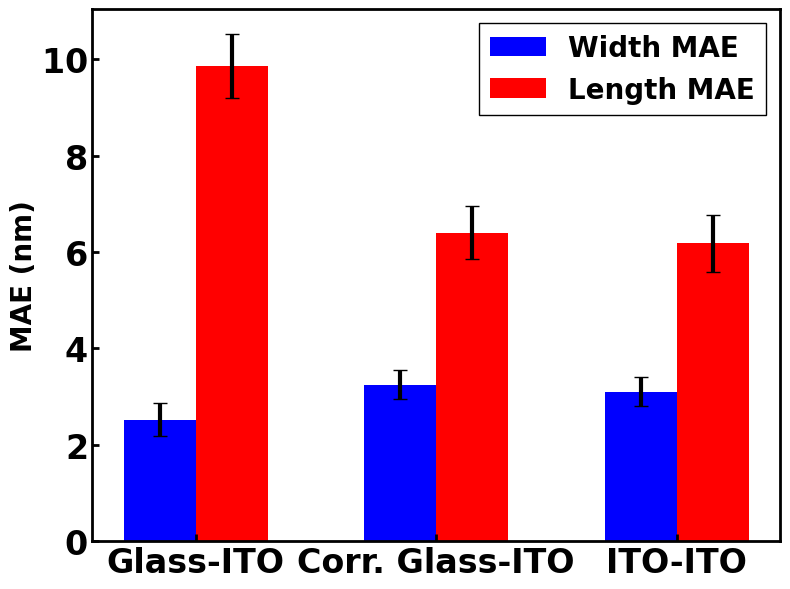

In [255]:
fig, ax = plt.subplots()

Width_MAE = (maew1_array.mean(), maew2_array.mean(), maew3_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean(), mael3_array.mean())

Width_MAE_errors = (maew1_array.std(), maew2_array.std(), maew3_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std(), mael3_array.std())

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

plt.xticks(index, ('Glass-ITO', 'Corr. Glass-ITO', 'ITO-ITO'))
ax.set_ylabel('MAE (nm)')

# ax1.set_yticks(np.arange(0.7, 1.0, 0.1))
# ax1.set_ylim(0.7, 1.05)

labels = ax.get_xticklabels()
plt.legend(fontsize=20)


# plt.setp(labels, rotation=-45, fontsize=30)
# ax1.hlines(y=0.95, xmin=-0.5, xmax=6.5, color='b', linewidth=2, linestyle='dotted')
# ax2.hlines(y=10, xmin=-0.5, xmax=6.5, color='r', linewidth=2, linestyle='dotted')
# ax2.spines['left'].set_color('b')
# ax2.spines['right'].set_color('r')
# ax1.tick_params(axis='y', colors='b')
# ax2.tick_params(axis='y', colors='r')
# ax1.yaxis.label.set_color('b')
# ax2.yaxis.label.set_color('r')

# ax1.tick_params(labelbottom=False,
#                labelleft=False,
#                labelright=False,
#                labeltop=False)
# ax2.tick_params(labelbottom=False,
#                labelleft=False,
#                labelright=False,
#                labeltop=False)

#     ax2.set_ylabel('RMSE (nm)')

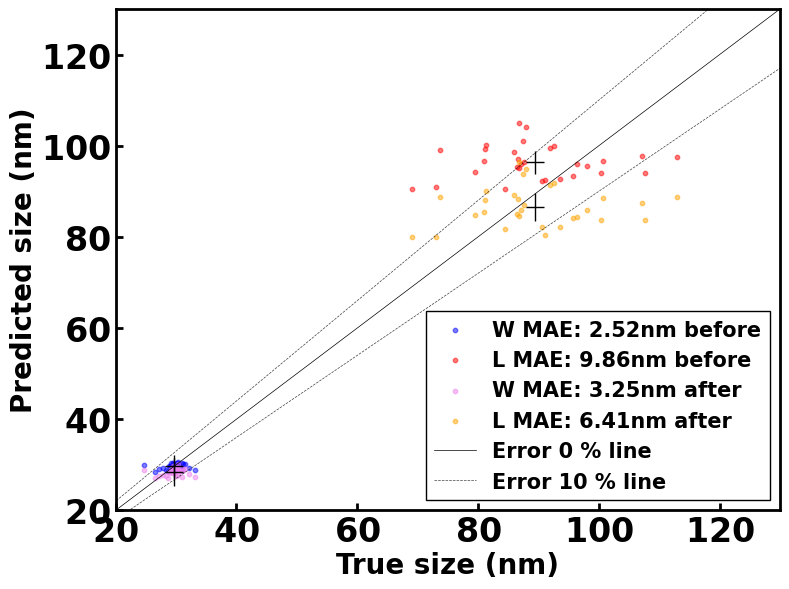

In [258]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, wmean1_list, s=10, c='b', alpha=.5, label=f'W MAE: {round(maew1_array.mean(), 2)}nm before')
ax.scatter(yl_exp_ito, lmean1_list, s=10, c='r', alpha=.5, label=f'L MAE: {round(mael1_array.mean(), 2)}nm before')

ax.errorbar(yw_exp_ito.mean(), np.mean(wmean1_list), yerr=np.mean(wstd1_list), xerr=1.5, linewidth=1, c='k')
ax.errorbar(yl_exp_ito.mean(), np.mean(lmean1_list), yerr=np.mean(lstd1_list), xerr=1.5, linewidth=1, c='k')

ax.scatter(yw_exp_ito, wmean2_list, s=10, c='violet', alpha=.5, label=f'W MAE: {round(maew2_array.mean(), 2)}nm after')
ax.scatter(yl_exp_ito, lmean2_list, s=10, c='orange', alpha=.5, label=f'L MAE: {round(mael2_array.mean(), 2)}nm after')

ax.errorbar(yw_exp_ito.mean(), np.mean(wmean2_list), yerr=np.mean(wstd2_list), xerr=1.5, linewidth=1, c='k')
ax.errorbar(yl_exp_ito.mean(), np.mean(lmean2_list), yerr=np.mean(lstd2_list), xerr=1.5, linewidth=1, c='k')

x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(20, 130)
ax.set_ylim(20, 130)
ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'B', ha='left', va='top', transform=ax.transAxes, fontsize=30)

(-30.000, 30.000)

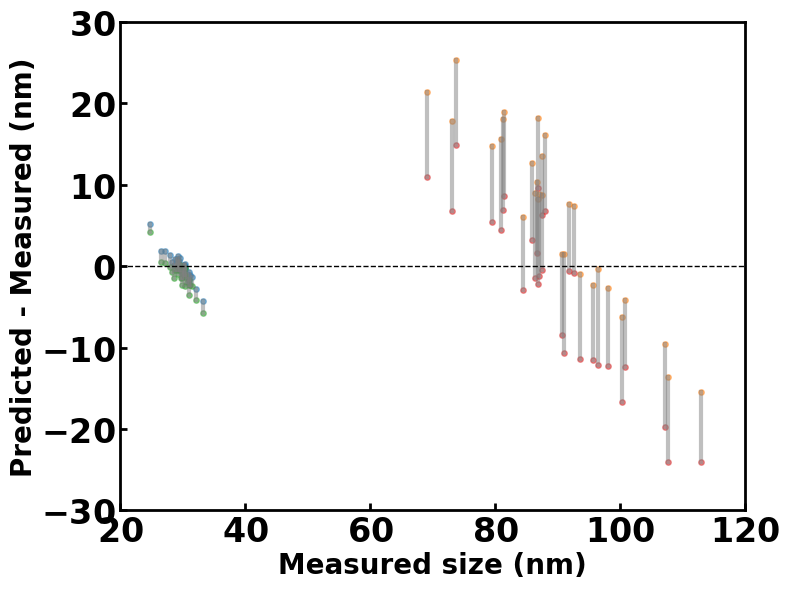

In [265]:
fig, ax = plt.subplots()

# Glass to ITO
ax.scatter(yw_exp_ito, wmean1_list-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew1_array.mean(), 2)} nm')
ax.scatter(yl_exp_ito, lmean1_list-yl_exp_ito, s=15, alpha=.5, label=f'MAE: {round(mael1_array.mean(), 2)} nm')

# Corrected Glass to ITO
ax.scatter(yw_exp_ito, wmean2_list-yw_exp_ito, s=15, alpha=.5, label=f'MAE: {round(maew2_array.mean(), 2)} nm')
ax.scatter(yl_exp_ito, lmean2_list-yl_exp_ito, s=15, alpha=.5, label=f'MAE: {round(mael2_array.mean(), 2)} nm')

for i in range(len(yw_exp_ito)):
    ax.plot([yw_exp_ito[i], yw_exp_ito[i]], [wmean1_list[i] - yw_exp_ito[i], wmean2_list[i] - yw_exp_ito[i]], color='gray', alpha=0.5)

for i in range(len(yl_exp_ito)):
    ax.plot([yl_exp_ito[i], yl_exp_ito[i]], [lmean1_list[i] - yl_exp_ito[i], lmean2_list[i] - yl_exp_ito[i]], color='gray', alpha=0.5)    
    
ax.axhline(y=0, lw=1, ls="--", c='k')

ax.set_xlabel('Measured size (nm)')
ax.set_ylabel('Predicted - Measured (nm)')
ax.set_xlim(20, 120)
ax.set_ylim(-30, 30)
# ax.legend(loc='lower right', fontsize=15)
# ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)